# What's going on with ROCAUC for Binary Classification?

We've identified [a bug in ROCAUC](https://github.com/DistrictDataLabs/yellowbrick/issues/252):

```
======================================================================
ERROR: Test ROCAUC with a binary classifier
----------------------------------------------------------------------
Traceback (most recent call last):
  File "/Users/benjamin/Repos/ddl/yellowbrick/tests/test_classifier/test_rocauc.py", line 110, in test_binary_rocauc
    s = visualizer.score(X_test, y_test)
  File "/Users/benjamin/Repos/ddl/yellowbrick/yellowbrick/classifier/rocauc.py", line 171, in score
    self.fpr[i], self.tpr[i], _ = roc_curve(y, y_pred[:,i], pos_label=c)
IndexError: too many indices for array
```

Let's see if we can figure out where it's getting triggered.

In [1]:
%matplotlib inline

In [2]:
import os
import sys 

# Modify the path 
sys.path.append("..")

import pandas as pd
import yellowbrick as yb
import matplotlib.pyplot as plt 

from yellowbrick.classifier import ROCAUC
from sklearn.model_selection import train_test_split

In [3]:
occupancy = pd.read_csv('data/occupancy/occupancy.csv')
features = [
    "temperature", "relative humidity", "light", "C02", "humidity"
]
classes = ["unoccupied", "occupied"]
X = occupancy[features]
y = occupancy['occupancy']

# Create the train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

## Binary Classification with 1D Coefficients or Feature Importances

When the function has 1D coefficients, we don't seem to have a problem

In [4]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

In [5]:
classifiers = [
    AdaBoostClassifier(),
    MLPClassifier(),
    DecisionTreeClassifier(),
    QuadraticDiscriminantAnalysis(),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
   ]

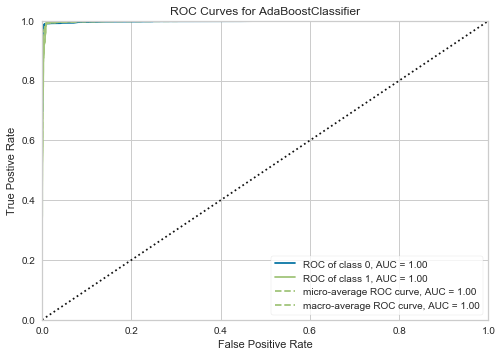

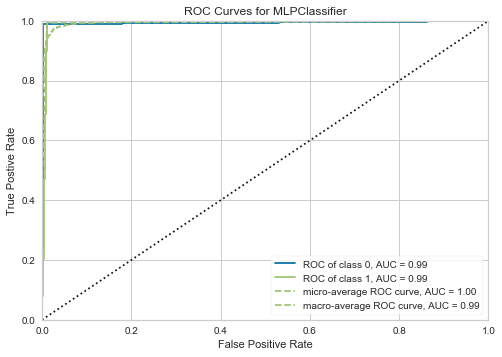

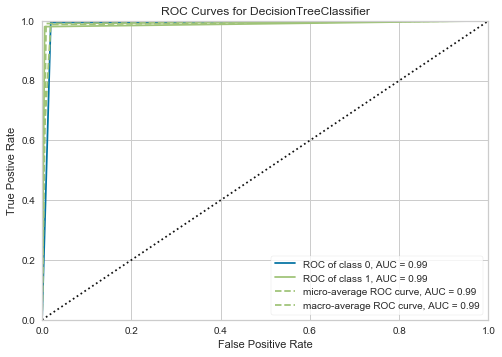

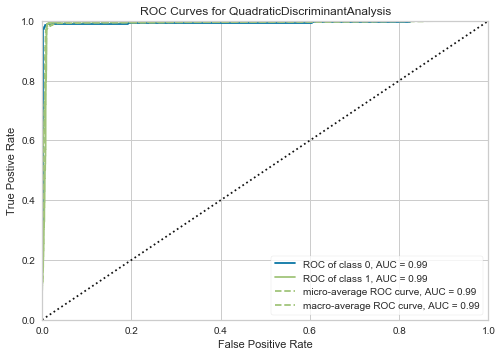

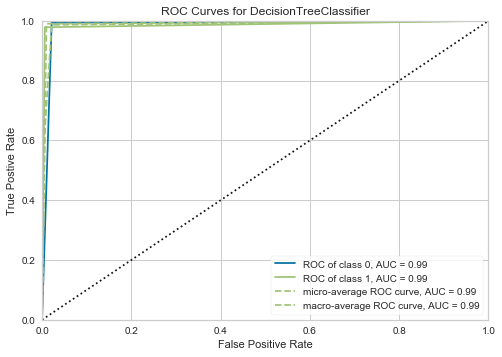

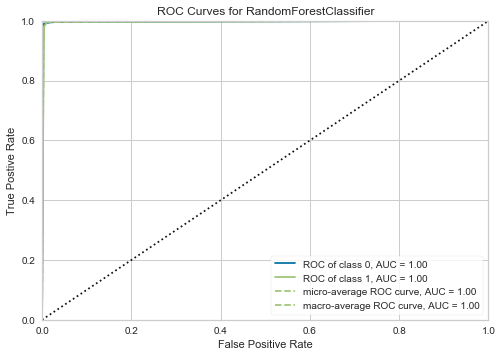

In [6]:
for classifier in classifiers:
    oz = ROCAUC(classifier)
    oz.fit(X_train, y_train)
    oz.score(X_test, y_test)
    g = oz.show()

Looks good; everything works!

## Binary Classification with Multidimensional Coefficients or Feature Importances

What about classification with estimators that have multidimensional coefficients? Thanks to ZJ Poh for identifying these in [this PR](https://github.com/DistrictDataLabs/yellowbrick/pull/510).

In [7]:
from sklearn.svm import LinearSVC, NuSVC, SVC
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.linear_model import RidgeClassifier, RidgeClassifierCV
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

Some of these generate the `IndexError: too many indices for array` error, but not all!

These are the ones that seem to work: `BernoulliNB()`, `MultinomialNB()`, `LogisticRegression()`, and `LogisticRegressionCV()`.

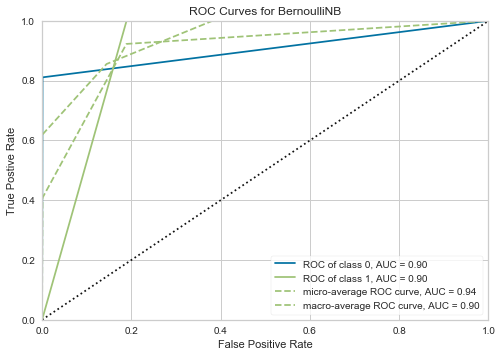

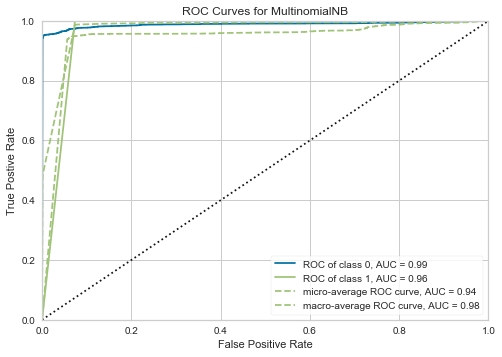

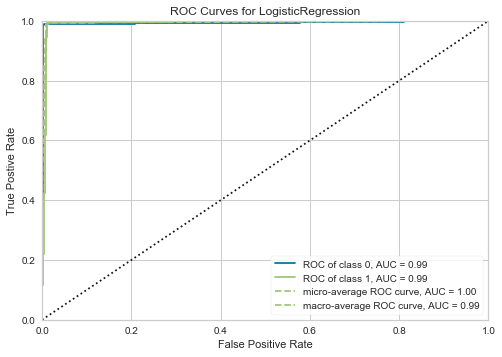

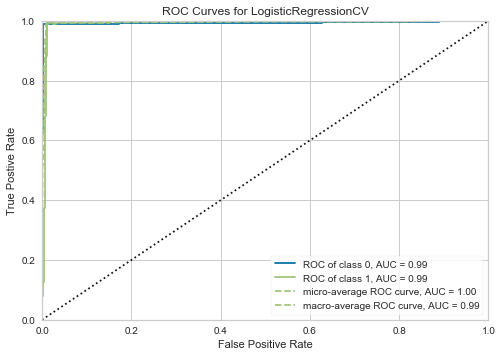

In [8]:
classifiers = [
    BernoulliNB(),
    MultinomialNB(),
    LogisticRegression(),
    LogisticRegressionCV()
]

for classifier in classifiers:
    oz = ROCAUC(classifier)
    oz.fit(X_train, y_train)
    oz.score(X_test, y_test)
    g = oz.show()

In [13]:
oz = ROCAUC(LinearSVC())
oz.fit(X_train, y_train)
oz.score(X_test, y_test)
oz.show()

IndexError: too many indices for array

In [14]:
oz = ROCAUC(SVC())
oz.fit(X_train, y_train)
oz.score(X_test, y_test)
oz.show()

IndexError: too many indices for array

In [15]:
oz = ROCAUC(SGDClassifier())
oz.fit(X_train, y_train)
oz.score(X_test, y_test)
oz.show()

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


IndexError: too many indices for array

In [10]:
oz = ROCAUC(PassiveAggressiveClassifier())
oz.fit(X_train, y_train)
oz.score(X_test, y_test)
oz.show()

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


IndexError: too many indices for array

In [11]:
oz = ROCAUC(RidgeClassifier())
oz.fit(X_train, y_train)
oz.score(X_test, y_test)
oz.show()

IndexError: too many indices for array

In [12]:
oz = ROCAUC(RidgeClassifierCV())
oz.fit(X_train, y_train)
oz.score(X_test, y_test)
oz.show()

IndexError: too many indices for array

so what's going on here?

### The Shape of `y_pred`

It looks like all of the classifiers that trigger the `IndexError` during binary classification with `ROCAUC` are ones that have only a `decision_function` and for which `y_pred.shape` is (n_samples,).

#### Classifiers that Raise the IndexError with Binary Classification & `ROCAUC`

 - [LinearSVC()](http://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html#sklearn.svm.LinearSVC.decision_function)
 - [SVC()](http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC.decision_function)
 - [SGDClassifier()](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html#sklearn.linear_model.SGDClassifier.decision_function)
 - [PassiveAggressiveClassifier()](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.PassiveAggressiveClassifier.html#sklearn.linear_model.PassiveAggressiveClassifier.decision_function)
 - [RidgeClassifier()](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeClassifier.html#sklearn.linear_model.RidgeClassifier.decision_function)
 - [RidgeClassifierCV()](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeClassifierCV.html#sklearn.linear_model.RidgeClassifierCV.decision_function)


In [16]:
attrs = (
    'predict_proba',
    'decision_function',
)

failing_classifiers = [
    LinearSVC(),                   
    SVC(),                     
    SGDClassifier(),              
    PassiveAggressiveClassifier(), 
    RidgeClassifier(),             
    RidgeClassifierCV()
]

In [17]:
def profile(classifiers):
    for classifier in classifiers:
        classifier.fit(X_train, y_train)
        # Return the first resolved function
        for attr in attrs:
            try:
                method = getattr(classifier, attr, None)
                if method:
                    y_pred = method(X_test)
            except AttributeError:
                continue
        print("y_pred shape for {} is {}.".format(
            classifier.__class__.__name__, y_pred.shape)
        ) 
        print(y_pred)

profile(failing_classifiers)

y_pred shape for LinearSVC is (4112,).
[-2.07818848 -1.10295589 -2.65880378 ... -1.5675887  -2.22618865
 -2.21660691]
y_pred shape for SVC is (4112,).
[-1.0042836  -1.04618017 -1.01206048 ... -0.50206514 -0.9921702
 -0.75343404]
y_pred shape for SGDClassifier is (4112,).
[-119987.75965156  -72882.79935914 -107597.19061436 ...  -68765.52714843
 -113531.54391398  -36124.36901115]
y_pred shape for PassiveAggressiveClassifier is (4112,).
[-2.29768419 -1.21982115 -2.12816317 ... -1.21089063 -2.20835107
 -1.04096801]
y_pred shape for RidgeClassifier is (4112,).
[-0.97824702 -0.72364345 -1.14475694 ... -0.79729413 -0.91117693
 -0.8346179 ]
y_pred shape for RidgeClassifierCV is (4112,).
[-0.97826157 -0.72362511 -1.14477574 ... -0.7972869  -0.91116793
 -0.83472035]


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and defau

### Classifiers that Currently Work with Binary Classification & `ROCAUC`

The classifiers with decision functions and `y_pred.shape` (n_samples, ) that *do* work with ROCAUC for binary classification seem to work because they also have `predict_proba`:

In [18]:
working_classifiers_decision = [
    AdaBoostClassifier(),
    QuadraticDiscriminantAnalysis(),
    LogisticRegression(),
    LogisticRegressionCV()
]

profile(working_classifiers_decision)

y_pred shape for AdaBoostClassifier is (4112,).
[-0.89443802 -0.75144235 -0.92373965 ... -0.74635979 -0.93102191
 -0.25120968]
y_pred shape for QuadraticDiscriminantAnalysis is (4112,).
[-25.52942121 -20.63607659 -21.32444067 ... -17.48076674 -15.83153313
 -27.96407765]
y_pred shape for LogisticRegression is (4112,).
[-7.21761368 -4.18943292 -9.03165307 ... -5.61892766 -7.64128122
 -7.31392629]
y_pred shape for LogisticRegressionCV is (4112,).
[-8.12155049 -4.86393333 -8.83520012 ... -5.89258174 -8.74651903
 -5.72819053]


#### Sklearn Documentation

 - [AdaBoostClassifier()](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html#sklearn.ensemble.AdaBoostClassifier.decision_function)
 - [QuadraticDiscriminantAnalysis()](http://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis.html#sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis.decision_function)
 - [LogisticRegression()](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression.decision_function)
 - [LogisticRegressionCV()](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegressionCV.html#sklearn.linear_model.LogisticRegressionCV.decision_function)

In [19]:
working_classifiers_proba = [
    MLPClassifier(),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    BernoulliNB(),
    MultinomialNB()
]

profile(working_classifiers_proba)

y_pred shape for MLPClassifier is (4112, 2).
[[9.99999821e-01 1.78587267e-07]
 [9.99999822e-01 1.77711818e-07]
 [9.99999416e-01 5.84020242e-07]
 ...
 [9.99999441e-01 5.59388516e-07]
 [9.99999211e-01 7.88712395e-07]
 [9.99264783e-01 7.35217361e-04]]
y_pred shape for DecisionTreeClassifier is (4112, 2).
[[1. 0.]
 [1. 0.]
 [1. 0.]
 ...
 [1. 0.]
 [1. 0.]
 [1. 0.]]
y_pred shape for RandomForestClassifier is (4112, 2).
[[1. 0.]
 [1. 0.]
 [1. 0.]
 ...
 [1. 0.]
 [1. 0.]
 [1. 0.]]
y_pred shape for BernoulliNB is (4112, 2).
[[9.99902348e-01 9.76522911e-05]
 [9.99902348e-01 9.76522911e-05]
 [9.99902348e-01 9.76522911e-05]
 ...
 [9.99902348e-01 9.76522911e-05]
 [9.99902348e-01 9.76522911e-05]
 [3.93484879e-01 6.06515121e-01]]
y_pred shape for MultinomialNB is (4112, 2).
[[1.00000000e+000 1.08610234e-097]
 [1.00000000e+000 1.29784432e-231]
 [1.00000000e+000 3.25319193e-078]
 ...
 [1.00000000e+000 5.25817964e-196]
 [1.00000000e+000 1.04606462e-075]
 [2.93149511e-065 1.00000000e+000]]


#### Sklearn Documentation
 
 - [MLPClassifier()](http://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html#sklearn.neural_network.MLPClassifier.predict_proba)
 - [DecisionTreeClassifier()](http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier.predict_proba)
 - [RandomForestClassifier()](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier.predict_proba)
 - [BernoulliNB()](http://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.BernoulliNB.html#sklearn.naive_bayes.BernoulliNB.predict_proba)
 - [MultinomialNB()](http://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html#sklearn.naive_bayes.MultinomialNB.predict_proba)
 
